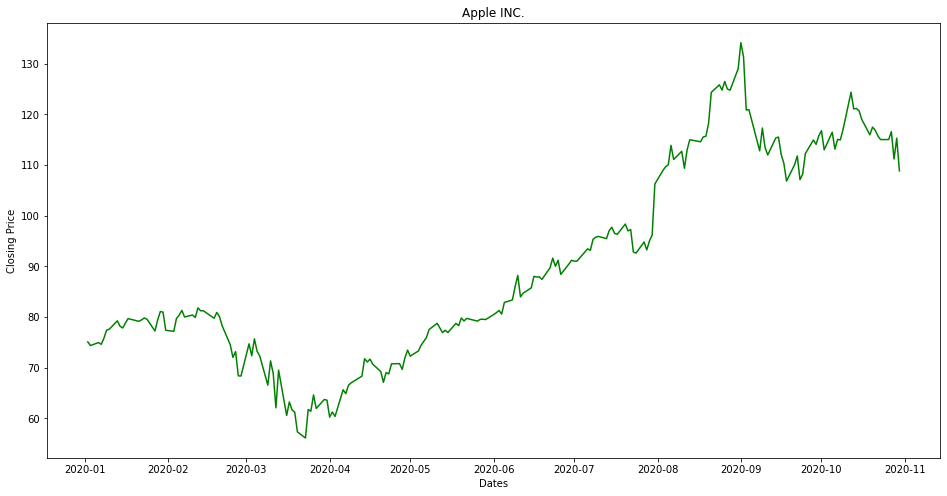

Calculating option price:
[[8.1679856e+02 1.6355632e+03 3.2735840e+03 6.5502400e+03 1.3104320e+04
  2.6213440e+04]
 [0.0000000e+00 4.0643320e+02 8.1532400e+02 1.6337200e+03 3.2712800e+03
  6.5473600e+03]
 [0.0000000e+00 0.0000000e+00 2.0075900e+02 4.0459000e+02 8.1302000e+02
  1.6308400e+03]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.7307500e+01 1.9845500e+02
  4.0171000e+02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.4813750e+01
  9.4427500e+01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.7606875e+01]]
BSM call=  20.742917081017083
BSM put=  220.14989347060737
S =  819.42
K =  1020
r =  0.01
t =  0.11506849315068493
sigma =  0.6966
d1 =  -0.8036087890894198
d2 =  -1.0399076799209663
Call Delta =  0.21081147278433515
Put Delta =  -0.7891885272156649
Gamma =  0.0014918011547566806
819.42 1020 0.01 0.11506849315068493 0.6966 -0.8036087890894198 -1.0399076799209663
-244.55062685827485
Call Theta =  -67.00017174199311
Put Theta =  -64.208

In [44]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as si
import sympy as sy
import pandas_datareader.data as web


stockcode = 'AAPL'
ts1 = str(int(datetime.datetime(2020,1,1).timestamp()))
ts2 = str(int(datetime.datetime(2020,10,31).timestamp()))

interval = '1d'

events = 'history'

url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stockcode +'?period1=' + ts1 + '&period2=' + ts2 + '&interval='+ interval + '&events=' + events
#print(url)
#print(ts1,ts2)

dframe = pd.read_csv(url)
#stockdata.size

dframe["Date"] = pd.to_datetime(dframe.Date, format = "%Y-%m-%d")
dframe.index =dframe['Date']

plt.figure(figsize=(16, 8))
plt.plot(dframe["Close"], label='Close Price History', color='g') 
plt.title('Apple INC.')
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.show()


#binomial

def binomial_model(N, S0, u, r, K):
    """
    N = number of binomial iterations
    S0 = initial stock price
    u = factor change of upstate
    r = risk free interest rate per annum
    K = strike price
    """
    d = 1 / u
    p = (1 + r - d) / (u - d)
    q = 1 - p

    # make stock price tree
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S * (u ** (i - j)) * (d ** j)

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N] - K))
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (1 / (1 + r) * (p * option[j, i + 1] + q * option[j + 1, i + 1]))
    return option


if __name__ == "__main__":
    print("Calculating option price:")
    op_price = binomial_model(5, 4, 2, 0.25, 8)
    print(op_price)




#  Functions that return d_1, d_2 and call and put prices
def d(sigma, S, K, r, t):
    d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(S/K) + (r + sigma**2/2) * t)
    d2 = d1 - sigma * np.sqrt(t)
    return d1, d2

def call_price(sigma, S, K, r, t, d1, d2):
    C = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * t)
    return C

def put_price(sigma, S, K, r, t, d1, d2):
    P = -norm.cdf(-d1) * S + norm.cdf(-d2) * K * np.exp(-r * t)
    return P

def BSM(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'c':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'p':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result
print("BSM call= ",BSM(S, K, t, r, sigma, option = 'c'))
print("BSM put= ",BSM(S, K, t, r, sigma, option = 'p'))






#  Functions for Delta, Gamma, Theta, Vega, Rho
def delta(d_1, contract_type):
    if contract_type == 'c':
        return norm.cdf(d1)
    if contract_type == 'p':
        return -norm.cdf(-d_1)
    
def gamma(d2, S, K, sigma, r, t):
    return( K * np.exp(-r * t) * (norm.pdf(d2) / (S**2 * sigma * np.sqrt(t) ))) 

def theta(d1, d2, S, K, sigma, r, t, contract_type):
    if contract_type == 'c':
        theta = -S * sigma * norm.pdf(d1) / (2 * np.sqrt(t)) - r * K * np.exp(-r * t) * norm.cdf(d2)
    if contract_type == 'p':
        theta = -S * sigma * norm.pdf(-d1) / (2 * np.sqrt(t)) + r * K * np.exp(-r * t) * norm.cdf(-d2)

    return theta

def vega(sigma, S, K, r, t):
    d1, d2 = d(sigma, S, K, r, t)
    v = S * norm.pdf(d1) * np.sqrt(t)
    return v

def rho(d2,S, K, t, r, sigma, option):
    rho = t * K * np.exp(-r * t) * si.norm.cdf(d2, 0.0, 1.0)
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    if option == 'c':
        rho = t * K * np.exp(-r * t) * si.norm.cdf(d2, 0.0, 1.0)
    if option == 'p':
        rho = -t * K * np.exp(-r * t) * si.norm.cdf(-d2, 0.0, 1.0)  
    return rho

S = 819.42; print('S = ', S)
K = 1020; print('K = ', K)
r = 0.01; print('r = ', r)
t = 42 / 365; print('t = ', t)
sigma = 0.6966; print('sigma = ', sigma)





#  Calculate the values of d1 and d2 needed for other functions
d1, d2 = d(sigma, S, K, r, t)
print('d1 = ', d1)
print('d2 = ', d2)

delta_call = delta(d1, 'c')
delta_put = delta(d1, 'p')
print('Call Delta = ', delta_call)
print('Put Delta = ', delta_put)




print( 'Gamma = ', gamma(d2, S, K, sigma, r, t))

print(S, K, r, t, sigma, d1, d2)
print( theta(d1, d2, S, K, sigma, r, t, 'c') )

print( 'Call Theta = ', theta(d1, d2, S, K, sigma, r, t, 'c') / 365 * 100)
print( 'Put Theta = ', theta(d1, d2, S, K, sigma, r, t, 'p') / 365 * 100)


print( 'Vega = ',vega(sigma, S, K, r, t) /100 )

print('Call Rho = ',rho(d2,S,K,t,r,sigma,'c'))
print('Put Rho = ',rho(d2,S,K,t,r,sigma,'p'))







